## Reproduce the BOSS cosmology results

Some notes and papers:

* https://nbodykit.readthedocs.io/en/latest/cookbook/convpower.html
* [Baryon Acoustic Oscillations](https://arxiv.org/abs/0910.5224) is a nice reference paper on the BAO feature.
* [BOSS LSS catalogs](https://www.sdss.org/dr14/spectro/lss/#BOSS)

#### Getting the data
* wget "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz"
* wget "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz"
* wget "https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_North.fits.gz"
* wget "https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASSLOWZTOT_South.fits.gz"

In [70]:
import os, pdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style
#from nbodykit.source.catalog import FITSCatalog
#from nbodykit.algorithms import SurveyData2PCF

In [3]:
plt.style.use(style.notebook)
%matplotlib inline

### Preliminaries

In [4]:
setup_logging()

In [5]:
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)

In [6]:
datadir = os.path.join(os.getenv('IM_DATA_DIR'), 'sdss', 'dr12')

In [138]:
def subsample_data(randoms=False, nsample=None, clobber=False):
    """Read and subsample the data or randoms LSS catalog, for speed.
    
    Here, we select objects with z=0.4-0.6 (see Alam+17, Table 2).
    
    """
    import fitsio
    import dask.array as da    
    
    if randoms:
        dataset = 'DR12v5-randoms'
        columns = ['RA', 'DEC', 'Z', 'WEIGHT_FKP',]
        infile = os.path.join(datadir, 'random0_DR12v5_CMASSLOWZTOT_North.fits.gz')
        outfile = os.path.join(datadir, 'subset_random0_DR12v5_CMASSLOWZTOT_North.fits')
    else:
        dataset = 'DR12v5'
        columns = ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT',]
        infile = os.path.join(datadir, 'galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz')
        outfile = os.path.join(datadir, 'subset_galaxy_DR12v5_CMASSLOWZTOT_North.fits')
        
    if not os.path.exists(outfile) or clobber:
        finfo = fitsio.FITS(infile)
        
        # Read a subset of the data.
        if nsample is None:
            rows = None
        else:
            rows = np.arange(0, finfo[1].get_nrows(), nsample)
            
        data = finfo[1].read(upper=True, columns=columns, rows=rows)
        #data = FITSCatalog(infile)
        print('Read {} / {} rows from {}'.format(len(data), finfo[1].get_nrows(), infile))
    
        keep = (data['Z'] > 0.4) * (data['Z'] < 0.6)
        nobj = np.sum(keep)
        print('Keeping {} / {} galaxies with 0.4<z<0.6.'.format(nobj, len(data)))
        _subdata = data[keep]
        #subdata = da.from_array(data[keep], chunks=np.sum(keep))
    
        # Add Cartesian coordinates
        xyzpos = transform.SkyToCartesian(_subdata['RA'], _subdata['DEC'], _subdata['Z'], cosmo=cosmo).compute()
        columns += ['POSITION']
        
        # This doesn't work!
        #np.lib.recfunctions.append_fields(_subdata, 'POSITION', xyzpos, dtypes=np.dtype(('POSITION', '>f8', (3,))))

        subdata = np.empty(_subdata.shape, dtype=np.dtype( _subdata.dtype.descr + [('POSITION', xyzpos.dtype, (3, ))] ))
        for ff in _subdata.dtype.fields:
            subdata[ff] = _subdata[ff]
        subdata['POSITION'] = xyzpos
        del _subdata
        
        print('Writing {} rows to {}'.format(nobj, outfile))
        #subdata.save(outfile, columns, dataset=dataset)
        fitsio.write(outfile, subdata, clobber=True)
        del subdata
    else:
        print('Reading {}'.format(outfile))
        out = FITSCatalog(outfile)
        
        #if not randoms:
        #    # Read and compute the statistical weight from Anderson+12, equation 18:
        #    out = FITSCatalog(outfile)
        #    out['Weight'] = out['WEIGHT_SYSTOT'] * ( out['WEIGHT_NOZ'] + out['WEIGHT_CP'] - 1 )
    
    return out

In [139]:
%time data = subsample_data(nsample=32, clobber=False)

[ 262207.08 ]   0: 01-03 06:29  CatalogSource   INFO     Extra arguments to FileType: ('/Users/ioannis/research/data/sdss/dr12/subset_galaxy_DR12v5_CMASSLOWZTOT_North.fits',) {}


Reading /Users/ioannis/research/data/sdss/dr12/subset_galaxy_DR12v5_CMASSLOWZTOT_North.fits
CPU times: user 4.12 ms, sys: 2.06 ms, total: 6.18 ms
Wall time: 4.47 ms


In [140]:
data.Weight().compute()

array([1., 1., 1., ..., 1., 1., 1.])

In [141]:
random.Weight

<bound method CatalogSource.Weight of FITSCatalog(size=813308, FileStack(FITSFile(path=/Users/ioannis/research/data/sdss/dr12/subset_random0_DR12v5_CMASSLOWZTOT_North.fits, dataset=None, ncolumns=5, shape=(813308,)>, ... 1 files))>

In [142]:
%time random = subsample_data(randoms=True, nsample=32, clobber=False)

[ 262217.22 ]   0: 01-03 06:29  CatalogSource   INFO     Extra arguments to FileType: ('/Users/ioannis/research/data/sdss/dr12/subset_random0_DR12v5_CMASSLOWZTOT_North.fits',) {}


Reading /Users/ioannis/research/data/sdss/dr12/subset_random0_DR12v5_CMASSLOWZTOT_North.fits
CPU times: user 3.56 ms, sys: 1.63 ms, total: 5.19 ms
Wall time: 10.2 ms


In [143]:
print('Data columns: {}'.format(data.columns))
print('Random columns: {}'.format(random.columns))

Data columns: ['DEC', 'POSITION', 'RA', 'Selection', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SYSTOT', 'Weight', 'Z']
Random columns: ['DEC', 'POSITION', 'RA', 'Selection', 'Value', 'WEIGHT_FKP', 'Weight', 'Z']


In [145]:
#rr = (data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1)).compute()
#data.Weight

### Generate n(z) for the data.

In [146]:
def get_nofz(totarea=9329, north=True):
    """Build n(z) for the data.  The total area is from Alam+17, Table 2.
    
    """
    from scipy.interpolate import InterpolatedUnivariateSpline
    
    if north:
        area = totarea * 5.3 / 7.3
    else:
        area = totarea * 2.0 / 7.3
    
    # compute n(z) from the randoms
    fsky = area / ( 4 * np.pi * (180 / np.pi)**2 ) # sky fraction from Alam+17
    zhist = RedshiftHistogram(random, fsky, cosmo, redshift='Z')
    
    # re-normalize to the total size of the data catalog
    alpha = 1.0 * data.csize / random.csize
    print('Renormalization factor = {:.5f}'.format(alpha))
    zhist.nbar *= alpha
    
    # Compute the interpolator we'll use below.
    nofz = InterpolatedUnivariateSpline(zhist.bin_centers, zhist.nbar)
    
    return zhist, nofz

In [147]:
def qa_zhist(zhist):
    fig, ax = plt.subplots()
    ax.plot(zhist.bin_centers, zhist.nbar)
    ax.set_xlabel(r'$z$', fontsize=16)
    ax.set_ylabel(r'$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$', fontsize=16)    

In [148]:
zhist, nofz = get_nofz()

[ 262245.33 ]   0: 01-03 06:29  RedshiftHistogram INFO     using Scott's rule to determine optimal binning; h = 1.90e-03, N_bins = 106
[ 262245.55 ]   0: 01-03 06:29  RedshiftHistogram INFO     using cosmology {'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'n_s': 0.9667, 'gauge': 'synchronous', 'N_ur': 2.0328, 'h': 0.7, 'T_cmb': 2.7255, 'N_ncdm': 1, 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0, 'Omega_b': 0.04775550899153668, 'Omega_cdm': 0.2609299279412303, 'm_ncdm': [0.06]} to compute volume in units of (Mpc/h)^3
[ 262245.55 ]   0: 01-03 06:29  RedshiftHistogram INFO     sky fraction used in volume calculation: 0.1642


Renormalization factor = 0.01922


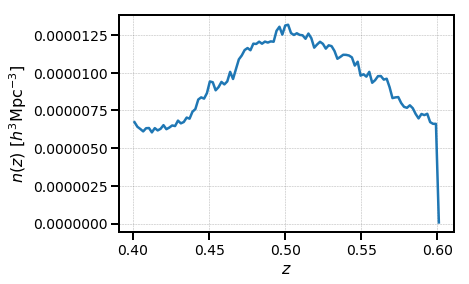

In [152]:
qa_zhist(zhist)

### Instantiate an FKPCatalog object by combining the data and randoms.

In [160]:
data['NZ'] = nofz(data['Z'])
random['NZ'] = nofz(random['Z'])
fkp = FKPCatalog(data, random)

fkp['data/FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
fkp['randoms/FKPWeight'] = 1.0 / (1 + fkp['randoms/NZ'] * 2e4)

fkp['data/Weight'] = (data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1)).compute()
fkp['randoms/Weight'] = np.ones(len(random))

In [164]:
data['NZ'].compute()

array([9.59187480e-06, 1.20108503e-05, 9.52562415e-06, ...,
       6.23083132e-06, 6.62146989e-06, 6.18484949e-06])

In [158]:
#fkp['data/FKPWeight'].compute(), data['WEIGHT_FKP'].compute()

In [162]:
fkp['data/Weight'].compute()

array([0.9976136 , 1.0001835 , 0.9981984 , ..., 1.5029838 , 0.97167385,
       1.1953032 ], dtype=float32)

In [167]:
help(fkp.to_mesh)

Help on method to_mesh in module nbodykit.algorithms.convpower.catalog:

to_mesh(Nmesh=None, BoxSize=None, BoxCenter=None, dtype='f4', interlaced=False, compensated=False, resampler='cic', fkp_weight='FKPWeight', comp_weight='Weight', selection='Selection', position='Position', bbox_from_species=None, window=None, nbar=None) method of nbodykit.algorithms.convpower.catalog.FKPCatalog instance
    Convert the FKPCatalog to a mesh, which knows how to "paint" the
    FKP density field.
    
    Additional keywords to the :func:`to_mesh` function include the
    FKP weight column, completeness weight column, and the column
    specifying the number density as a function of redshift.
    
    Parameters
    ----------
    Nmesh : int, 3-vector, optional
        the number of cells per box side; if not specified in `attrs`, this
        must be provided
    dtype : str, dtype, optional
        the data type of the mesh when painting
    interlaced : bool, optional
        whether to use inter

In [168]:
mesh = fkp.to_mesh(Nmesh=256, nbar='NZ', comp_weight='Weight', fkp_weight='FKPWeight', position='data/POSITION')

ValueError: source does not contain columns: {'data/POSITION'}; try adding columns via `source[column] = data`